# Modified ILC weights for bias and noise reduction

In [1]:
# imports

from __future__ import print_function
from __future__ import division
from builtins import map
import universe
from universe import *

import halo_fit
from halo_fit import *

import weight
from weight import *


import pn_2d
from pn_2d import *

import cmb
from cmb import *

import flat_map
from flat_map import *

import pandas as pd

import cmb_ilc
from cmb_ilc import *

import scipy

from headers import*

from SO_noise2 import*

from scipy.interpolate import interp1d

In [2]:
##################################################################################
# make plots prettier
import matplotlib
from matplotlib.pyplot import rc
import matplotlib.font_manager

rc('font',**{'size':'22','family':'serif','serif':['CMU serif']})
rc('mathtext', **{'fontset':'cm'})
rc('text', usetex=True)
rc('legend',**{'fontsize':'18'})

matplotlib.rcParams['axes.linewidth'] = 3
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 25 
matplotlib.rcParams['ytick.labelsize'] = 25
matplotlib.rcParams['legend.fontsize'] = 25
#matplotlib.rcParams['legend.title_fontsize'] = 25
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['xtick.major.width'] = 3
matplotlib.rcParams['ytick.major.width'] = 3
matplotlib.rcParams['xtick.minor.width'] = 1.5
matplotlib.rcParams['ytick.minor.width'] = 1.5
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Setup

In [56]:
from astropy import units as u
freq = 150 * u.GHz
equiv = u.thermodynamic_temperature(freq)
(0.75 * 60 * u.kJy / u.sr).to(u.mK, equivalencies=equiv) * 1000

<Quantity 112.92889097 mK>

In [ ]:
780, 31000

In [57]:
# Specifications
Nu = np.array([27.e9,39.e9,93.e9,145.e9,225.e9,280.e9]) # [Hz]
Beam = np.array([7.4,5.1,2.2,1.4,1.0,0.9])
#Noise = np.array([71., 36., 8., 10., 22., 54.])  # [muK*arcmin]
Noise = np.array([52.,27.,5.8,6.3,15.,37.])

# adding Planck 
Nu = np.array([27.e9,39.e9,93.e9,145.e9,225.e9,280.e9,353.e9,545.e9,857.e9]) # [Hz]
Beam = np.array([7.4,5.1,2.2,1.4,1.0,0.9,5,4.7,4.2])
Noise = np.array([52.,27.,5.8,6.3,15.,37.,150.,780.,31000.])

# init

cmbIlc = CMBILC(Nu, Beam, Noise, atm=True)

/home/noah/Berkeley/LensQuEst-1/basic_functions.py:98: RuntimeWarning: divide by zero encountered in true_divide
  try: return x/y
/home/noah/Berkeley/LensQuEst-1/cmb.py:127: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:135: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl
/home/noah/Berkeley/LensQuEst-1/cmb.py:149: RuntimeWarning: invalid value encountered in multiply
  data[:,1] *= self.fdl_to_cl(data[:,0]) # convert Dl to Cl


In [58]:
lMin = 10.
lMax = 3000.

LMin = 20.
LMax = 1.e3

nBands = 9
nBins = 21

octantArea = 4.*np.pi * (180./np.pi)**2   # deg 2
octantArea /= 8.
ourArea = 81. * 20.**2  # deg 2
uncertaintyFactor = np.sqrt(ourArea / octantArea)

data = pd.read_csv('output/mean_biases.csv')
data2 = pd.read_csv('output/Ckk_biases_lmaxT_3500.csv')
lCen = np.array(data['lCen'])
I = np.where((lCen>=LMin)*(lCen<=LMax))
lEdges = np.logspace(np.log10(1.), np.log10(np.max(15273.50)), nBins, 10.) # Edges of the bins
Nmodes = np.array(data2['Nmodes'])

In [59]:
nX = 400
nY = 400
size = 10.  # degrees, determined by the Sehgal cutouts
baseMap = FlatMap(nX=nX, nY=nY, sizeX=size*np.pi/180., sizeY=size*np.pi/180.)

In [60]:
u = UnivPlanck15()
halofit = Halofit(u, save=False)
w_cmblens = WeightLensSingle(u, z_source=1100., name="cmblens")
w_lsstgold = WeightTracerLSSTGold(u)
p2d_cmblens = P2dAuto(u, halofit, w_cmblens, save=False)
ClkCmb = p2d_cmblens.fPinterp(lCen)

p2d_lsstgold = P2dAuto(u, halofit, w_lsstgold, fPnoise=lambda l:1./w_lsstgold.ngal, nProc=3, save=True)
p2d_lsstgoldcmblens = P2dCross(u, halofit, w_lsstgold, w_cmblens, nProc=3, save=True)
Ckg = p2d_lsstgoldcmblens.fPtotinterp(lCen)
Cgg = p2d_lsstgold.fPtotinterp(lCen)

L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 501, 10.)

weightsIlcCmb = np.array([cmbIlc.weightsIlcCmb(l) for l in L])

weightsIlcCmb_jointDeproj = np.array([cmbIlc.weightsDeprojTszCIB(l) for l in L])

weightsIlcCmb_tszdeproj = np.array([cmbIlc.weightsDeprojTsz(l) for l in L])

weightsIlcCmb_cibdeproj = np.array([cmbIlc.weightsDeprojCIB(l) for l in L])

In [61]:
def ctot(weights,l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*(weightsIlcCmb[lindex][i]+weights[i])*(weightsIlcCmb[lindex][j]+weights[j])
   return result
            
def ctot_deproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*weightsIlcCmb_jointDeproj[lindex][i]*weightsIlcCmb_jointDeproj[lindex][j]
   return result    
    
def ctot_tszdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*weightsIlcCmb_tszdeproj[lindex][i]*weightsIlcCmb_tszdeproj[lindex][j]
   return result

def ctot_cibdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftotalTT(l)*weightsIlcCmb_cibdeproj[lindex][i]*weightsIlcCmb_cibdeproj[lindex][j]
   return result

In [62]:
fCtotal = np.array([ctot(np.zeros(nBands),l,lindex) for lindex,l in enumerate(L)])
fCtotal_deproj = np.array([ctot_deproj(l,lindex) for lindex,l in enumerate(L)])
fCtotal_tszdeproj = np.array([ctot_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
fCtotal_cibdeproj = np.array([ctot_cibdeproj(l,lindex) for lindex,l in enumerate(L)])

In [63]:
def cTsz(weights,l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*(weightsIlcCmb[lindex][i]+weights[i])*(weightsIlcCmb[lindex][j]+weights[j])
   return result
            
def cTsz_deproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*weightsIlcCmb_jointDeproj[lindex][i]*weightsIlcCmb_jointDeproj[lindex][j]
   return result    
    
def cTsz_tszdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*weightsIlcCmb_tszdeproj[lindex][i]*weightsIlcCmb_tszdeproj[lindex][j]
   return result

def cTsz_cibdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].ftSZ(l)*weightsIlcCmb_cibdeproj[lindex][i]*weightsIlcCmb_cibdeproj[lindex][j]
   return result

In [64]:
fCTsz = np.array([cTsz(np.zeros(nBands),l,lindex) for lindex,l in enumerate(L)])
fCTsz_deproj = np.array([cTsz_deproj(l,lindex) for lindex,l in enumerate(L)])
fCTsz_tszdeproj = np.array([cTsz_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
fCTsz_cibdeproj = np.array([cTsz_cibdeproj(l,lindex) for lindex,l in enumerate(L)])
fCTsz148 = np.array([cmbIlc.cmb[3,3].ftSZ(l) for l in L])

In [65]:
def cCIB(weights,l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*(weightsIlcCmb[lindex][i]+weights[i])*(weightsIlcCmb[lindex][j]+weights[j])
   return result
            
def cCIB_deproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*weightsIlcCmb_jointDeproj[lindex][i]*weightsIlcCmb_jointDeproj[lindex][j]
   return result    
    
def cCIB_tszdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*weightsIlcCmb_tszdeproj[lindex][i]*weightsIlcCmb_tszdeproj[lindex][j]
   return result

def cCIB_cibdeproj(l,lindex):
   result = 0.
   for i in range(nBands):
      for j in range(nBands):
         result += cmbIlc.cmb[i,j].fCIB(l)*weightsIlcCmb_cibdeproj[lindex][i]*weightsIlcCmb_cibdeproj[lindex][j]
   return result

In [66]:
fCCIB = np.array([cCIB(np.zeros(nBands),l,lindex) for lindex,l in enumerate(L)])
fCCIB_deproj = np.array([cCIB_deproj(l,lindex) for lindex,l in enumerate(L)])
fCCIB_tszdeproj = np.array([cCIB_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
fCCIB_cibdeproj = np.array([cCIB_cibdeproj(l,lindex) for lindex,l in enumerate(L)])
fCCIB148 = np.array([cmbIlc.cmb[3,3].fCIB(l) for l in L])

# Figure 1.

Text(0, 0.5, '$C_\\ell/C^\\text{150 GHz}_\\ell$')

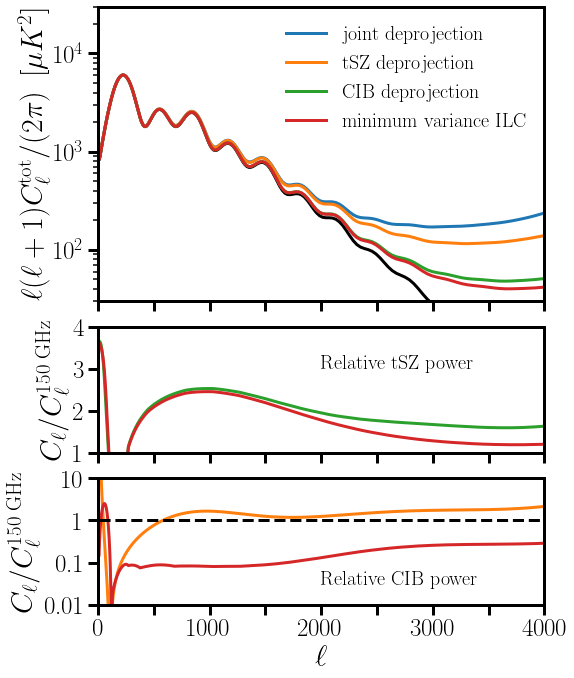

In [67]:
fig,ax = plt.subplots(3,1,figsize=(8,11),sharex=True,gridspec_kw={'height_ratios':[0.7,0.3,0.3],'hspace':0.14})

signal = np.array([cmbIlc.cmb[0,0].flensedTT(l) for l in L])

ax[0].semilogy(L,signal*L*(L+1)/(2.*np.pi),color='k',lw=3)

ax[0].semilogy(L,fCtotal_deproj*L*(L+1.)/(2.*np.pi),color='C0',label='joint deprojection',lw=3)
ax[0].semilogy(L,fCtotal_tszdeproj*L*(L+1.)/(2.*np.pi),color='C1',label='tSZ deprojection',lw=3)
ax[0].semilogy(L,fCtotal_cibdeproj*L*(L+1.)/(2.*np.pi),color='C2',label='CIB deprojection',lw=3)
ax[0].semilogy(L,fCtotal*L*(L+1.)/(2.*np.pi),color='C3',label='minimum variance ILC',lw=3)

ax[1].plot(L,fCTsz_cibdeproj/fCTsz148,color='C2',lw=3,label='CIB deprojection')
ax[1].plot(L,fCTsz/fCTsz148,color='C3',lw=3,label='minimum variance ILC')
ax[1].plot(L,np.ones(L.shape),c='k',lw=3,label='148 GHz',ls='--')

ax[2].semilogy(L,fCCIB_tszdeproj/fCCIB148,color='C1',label='tSZ deprojection',lw=3)
ax[2].semilogy(L,fCCIB/fCCIB148,color='C3',label='minimum variance ILC',lw=3)
ax[2].plot(L,np.ones(L.shape),c='k',lw=3,label='148 GHz',ls='--')


ax[0].set_xlim(0,4000)
ax[0].set_ylim(30,3e4)

ax[2].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$\ell(\ell+1)C^\text{tot}_\ell/(2\pi)\,\,\,[\mu K^2]$')
ax[0].legend(loc=0,frameon=False,fontsize=20)
#ax[1].legend(loc=0,frameon=False,fontsize=20)
#ax[2].legend(loc=0,frameon=False,fontsize=20)

ax[1].set_yticks([1,2,3,4])
ax[1].set_ylim(1,4)

ax[2].set_yticks([10,1,0.1,0.01])
ax[2].set_yticklabels([10,1,0.1,0.01])
ax[2].set_ylim(0.01,10)

ax[2].set_xticks([0,500,1000,1500,2000,2500,3000,3500,4000])
ax[2].set_xticklabels([0,'',1000,'',2000,'',3000,'',4000])

ax[1].text(2000,3,r'Relative tSZ power',fontsize=20)
ax[2].text(2000,3e-2,r'Relative CIB power',fontsize=20)

ax[1].set_ylabel(r'$C_\ell/C^\text{150 GHz}_\ell$')
ax[2].set_ylabel(r'$C_\ell/C^\text{150 GHz}_\ell$')

#plt.savefig('figures/ILC_noises.pdf',bbox_inches='tight')

# Figure 2.

## Calculating noises

In [ ]:
fCtotal = np.array([ctot(np.zeros(6),l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

In [ ]:
fCtotal = np.array([ctot_deproj(l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft_deproj = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

In [ ]:
fCtotal = np.array([ctot_tszdeproj(l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft_tszdeproj = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

In [ ]:
fCtotal = np.array([ctot_cibdeproj(l,lindex) for lindex,l in enumerate(L)])
interp_ctot = interp1d(L, fCtotal, kind='linear', bounds_error=False, fill_value=0.)
fNqCmb_fft_cibdeproj = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, interp_ctot, lMin=lMin, lMax=lMax, test=False)

## loading biases

In [ ]:
N = 81

octantArea = 4.*np.pi * (180./np.pi)**2   # deg 2
octantArea /= 8.
ourArea = N * 20.**2  # deg 2
uncertaintyFactor = np.sqrt(ourArea / octantArea)

def get_data(name,t,i):
    path = name + '/' + str(int(lMax)) + '/' + "output_t_"+"{0:0=2d}".format(int(t*10)) 
    dataAvg = np.genfromtxt(path+'/data_lmaxT_'+str(int(lMax))+'_'+str(i)+'.txt')
    i=0
    # All extragalactic foregrounds (scale dep)
    # 
    # Trispectrum
    ClqCmbAllScaleDep = dataAvg[int(0+16*i)]
    ClsCmbAllScaleDep = dataAvg[int(1+16*i)]
    ClBHCmbAllScaleDep = dataAvg[int(2+16*i)]
    ClBHPCmbAllScaleDep = dataAvg[int(3+16*i)]
    # Primary
    ClqCmbAllScaleDepKappa = dataAvg[int(4+16*i)]
    ClsCmbAllScaleDepKappa = dataAvg[int(5+16*i)]
    ClBHCmbAllScaleDepKappa = dataAvg[int(6+16*i)]
    ClBHPCmbAllScaleDepKappa = dataAvg[int(7+16*i)]
    # k_rec x LSST 
    ClqCmbAllScaleDepLsstgold = dataAvg[int(8+16*i)]
    ClsCmbAllScaleDepLsstgold = dataAvg[int(9+16*i)]
    ClBHCmbAllScaleDepLsstgold = dataAvg[int(10+16*i)]
    ClBHPCmbAllScaleDepLsstgold = dataAvg[int(11+16*i)]
    # Secondary
    ClqCmbAllScaleDepSec = dataAvg[int(12+16*i)]
    ClsCmbAllScaleDepSec = dataAvg[int(13+16*i)]
    ClBHCmbAllScaleDepSec = dataAvg[int(14+16*i)]
    ClBHPCmbAllScaleDepSec = dataAvg[int(15+16*i)]
    
    bias_list = np.array([ 
    ClqCmbAllScaleDepKappa*2/ClkCmb,
    ClBHCmbAllScaleDepKappa*2/ClkCmb,
    ClBHPCmbAllScaleDepKappa*2/ClkCmb,
    ClsCmbAllScaleDepKappa*2/ClkCmb,
    ClqCmbAllScaleDepSec*2/ClkCmb,
    ClBHCmbAllScaleDepSec*2/ClkCmb,
    ClBHPCmbAllScaleDepSec*2/ClkCmb,
    ClsCmbAllScaleDepSec*2/ClkCmb,
    ClqCmbAllScaleDep/ClkCmb,
    ClBHCmbAllScaleDep/ClkCmb,
    ClBHPCmbAllScaleDep/ClkCmb,
    ClsCmbAllScaleDep/ClkCmb,
    #
    ClqCmbAllScaleDepLsstgold/Ckg,
    ClBHCmbAllScaleDepLsstgold/Ckg,
    ClBHPCmbAllScaleDepLsstgold/Ckg,
    ClsCmbAllScaleDepLsstgold/Ckg])
    
    return bias_list

def QE_bias_L(name,t):
    bias_list = np.array([get_data(name,t,i) for i in range(N)])
    QE_biases = np.array([b[0]+b[4]+b[8] for b in bias_list])
    mean = np.mean(QE_biases,axis=0)
    std = np.std(QE_biases,axis=0)*uncertaintyFactor/np.sqrt(N)
    return mean, std

def all_estimators_bias_L(name,t):
    bias_list = np.array([get_data(name,t,i) for i in range(N)])
    QE_biases = np.array([b[0]+b[4]+b[8] for b in bias_list])
    PSH_biases = np.array([b[1]+b[5]+b[9] for b in bias_list])
    PH_biases = np.array([b[2]+b[6]+b[10] for b in bias_list])
    Shear_biases = np.array([b[3]+b[7]+b[11] for b in bias_list])
    return QE_biases, PSH_biases, PH_biases, Shear_biases

def all_estimators_cross_bias_L(name,t):
    bias_list = np.array([get_data(name,t,i) for i in range(N)])
    QE_biases = np.array([b[12] for b in bias_list])
    PSH_biases = np.array([b[13] for b in bias_list])
    PH_biases = np.array([b[14] for b in bias_list])
    Shear_biases = np.array([b[15] for b in bias_list])
    return QE_biases, PSH_biases, PH_biases, Shear_biases

In [ ]:
b_ILC,sb_ILC = QE_bias_L('ILC_to_Joint',0)
b_joint,sb_joint = QE_bias_L('ILC_to_Joint',1)
b_tSZ,sb_tSZ = QE_bias_L('ILC_to_tSZ',1)
b_CIB,sb_CIB = QE_bias_L('ILC_to_CIB',1)

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(8,10),gridspec_kw={'height_ratios':[1,0.4],'hspace':0.2})

ax[0].loglog(L,p2d_cmblens.fPinterp(L),c='k',lw=3)
ax[0].loglog(L,fNqCmb_fft_deproj(L),lw=3,c='C0',label='joint deprojection')
#ax[0].loglog(L,fNqCmb_fft_dumb(L),lw=3,c='C4',label='tSZ + CIB deprojection')
ax[0].loglog(L,fNqCmb_fft_tszdeproj(L),lw=3,c='C1',label='tSZ deprojection')
ax[0].loglog(L,fNqCmb_fft_cibdeproj(L),lw=3,c='C2',label='CIB deprojection')
ax[0].loglog(L,fNqCmb_fft(L),lw=3,c='C3',label='minimum variance ILC')


ax[1].semilogx(lCen,b_joint,c='C0',lw=3)
ax[1].fill_between(lCen,b_joint-sb_joint,b_joint+sb_joint,color='C0',alpha=0.3)

ax[1].semilogx(lCen,b_tSZ,c='C1',lw=3)
ax[1].fill_between(lCen,b_tSZ-sb_tSZ,b_tSZ+sb_tSZ,color='C1',alpha=0.3)

ax[1].semilogx(lCen,b_CIB,c='C2',lw=3)
ax[1].fill_between(lCen,b_CIB-sb_CIB,b_CIB+sb_CIB,color='C2',alpha=0.3)

ax[1].semilogx(lCen,b_ILC,c='C3',lw=3)
ax[1].fill_between(lCen,b_ILC-sb_ILC,b_ILC+sb_ILC,color='C3',alpha=0.3)


sigma = np.sqrt(2. * (ClkCmb + fNqCmb_fft(lCen))**2 / Nmodes)
sigma0 = np.array(list(zip(sigma/ClkCmb, sigma/ClkCmb))).flatten()
l0 = np.array(list(zip(lEdges[:-1],lEdges[1:]))).flatten()
ax[1].fill_between(l0, -sigma0, sigma0, edgecolor='k', facecolor='gray', alpha=0.4)

ax[0].set_ylabel(r'$N^\kappa_L$')
ax[1].set_xlabel(r'$L$')
ax[1].set_ylabel(r'Relative bias')

ax[0].legend(loc=0,frameon=False,fontsize=20)

ax[0].set_xlim(30,6000)
ax[0].set_ylim(1e-8,5e-4)

ax[1].set_xlim(30,1000)
ax[1].set_ylim(-0.2,0.2)
#ax[1].set_yticks([-0.2,0,0.2,0.35])

plt.savefig('figures/Nk_bias_vs_L_3000.pdf',bbox_inches='tight')

# Figure 3.

In [ ]:
tmp_ells = np.logspace(np.log10(lMin),np.log10(2*lMax),5001)
for i in range(6):
   for j in range(6):
      forCtot = np.array([cmbIlc.cmb[i,j].ftotalTT(l) for l in tmp_ells])
      cmbIlc.cmb[i,j].ftotalTT = interp1d(tmp_ells,forCtot)

In [ ]:
tmp_ells = np.logspace(np.log10(lMin),np.log10(2*lMax),5001)
wILCTrue = np.array([cmbIlc.weightsIlcCmb(l) for l in tmp_ells]).T
wILCTrue_interp = np.array([interp1d(tmp_ells,wILCTrue[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

wJointDeproj = np.array([cmbIlc.weightsDeprojTszCIB(l) for l in tmp_ells]).T
wJointDeproj_interp = np.array([interp1d(tmp_ells,wJointDeproj[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

wCIBDeproj = np.array([cmbIlc.weightsDeprojCIB(l) for l in tmp_ells]).T
wCIBDeproj_interp = np.array([interp1d(tmp_ells,wCIBDeproj[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

wTszDeproj = np.array([cmbIlc.weightsDeprojTsz(l) for l in tmp_ells]).T
wTszDeproj_interp = np.array([interp1d(tmp_ells,wTszDeproj[i],bounds_error=False,fill_value=0) for i in range(len(Nu))])

def wILC_interp(t,u,v,l,i): return wILCTrue_interp[i](l) + t*(wJointDeproj_interp[i](l)-wILCTrue_interp[i](l))+ u*(wCIBDeproj_interp[i](l)-wILCTrue_interp[i](l))+ v*(wTszDeproj_interp[i](l)-wILCTrue_interp[i](l))

def ctot(t,u,v,l):
  result = 0
  for i in range(len(Nu)):
     for j in range(len(Nu)):
        result += cmbIlc.cmb[i,j].ftotalTT(l)*wILC_interp(t,u,v,l,i)*wILC_interp(t,u,v,l,j)
  return result

def ctot_interp(t,u,v):
   L = np.logspace(np.log10(lMin),np.log10(2*lMax),5001)
   forCtot = np.array([ctot(t,u,v,l) for l in L])
   fCtotal = interp1d(L, forCtot, kind='linear', bounds_error=False, fill_value=np.inf)
   return fCtotal

def ctSZCIB(t,u,v,l):
  result = 0
  for i in range(len(Nu)):
     for j in range(len(Nu)):
        result += (cmbIlc.cmb[i,j].ftSZ(l)+cmbIlc.cmb[i,j].fCIB(l)+cmbIlc.cmb[i,j].ftSZ_CIB(l))*wILC_interp(t,u,v,l,i)*wILC_interp(t,u,v,l,j)
  return result

def ctSZCIB_interp(t,u,v):
   L = np.logspace(np.log10(lMin),np.log10(2*lMax),5001)
   forCtot = np.array([ctSZCIB(t,u,v,l) for l in L])
   fCtotal = interp1d(L, forCtot, kind='linear', bounds_error=False, fill_value=np.inf)
   return fCtotal

In [23]:
l = np.genfromtxt('l.txt')
profile = np.genfromtxt('profile.txt')
uTsz = interp1d(l,profile,kind='linear')

def get_noises(t,u,v):
   fCtotal = ctot_interp(t,u,v)
   fNqCmb_fft = baseMap.forecastN0Kappa(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, test=False)(lCen)
   fNsCmb_fft = baseMap.forecastN0KappaShear(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, corr=True, test=False)(lCen)
   fNqBHCmb_fft = baseMap.forecastN0KappaBH(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, test=False)(lCen)
   fNqBHPCmb_fft = baseMap.forecastN0KappaBH(cmbIlc.cmb[0,0].flensedTT, fCtotal, lMin=lMin, lMax=lMax, test=False, u=uTsz)(lCen)
   return fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft

In [24]:
def Alens_biases_ILC_to_Joint(t):
   fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft = get_noises(t,0,0)
   QE_biases, PSH_biases, PH_biases, Shear_biases = all_estimators_bias_L('ILC_to_Joint',t)
   QE_biasesx, PSH_biasesx, PH_biasesx, Shear_biasesx = all_estimators_cross_bias_L('ILC_to_Joint',t)
        
   # QE 
   s2 =  2. * (ClkCmb + fNqCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   QE_bs = np.array([ np.sum(np.abs(biasq[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasq in QE_biases ])
   QE_bs2 = np.array([ np.abs(np.sum(biasq[I] * ClkCmb[I]**2 / s2[I])) / norm for biasq in QE_biases ])
   QE_mean = np.mean(QE_bs)
   QE_std = np.std(QE_bs)*uncertaintyFactor/np.sqrt(N)
   QE_mean2 = np.mean(QE_bs2)
   QE_std2 = np.std(QE_bs2)*uncertaintyFactor/np.sqrt(N)
   QE_noise = np.sqrt(noise)
   #
   # QE cross 
   s2 = ((ClkCmb + fNqCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2 / s2[I])
   noise = 1./norm
   QE_bs = np.array([ np.sum(np.abs(biasq[I]) * Ckg[I]**2 / s2[I]) / norm for biasq in QE_biasesx ])
   QE_bs2 = np.array([ np.abs(np.sum(biasq[I] * Ckg[I]**2 / s2[I])) / norm for biasq in QE_biasesx ])
   QE_meanx = np.mean(QE_bs)
   QE_stdx = np.std(QE_bs)*uncertaintyFactor/np.sqrt(N)
   QE_mean2x = np.mean(QE_bs2)
   QE_std2x = np.std(QE_bs2)*uncertaintyFactor/np.sqrt(N)
   QE_noisex = np.sqrt(noise)
   
    
   # Shear 
   s2 =  2. * (ClkCmb + fNsCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   Shear_bs = np.array([ np.sum(np.abs(biass[I]) * ClkCmb[I]**2 / s2[I]) / norm for biass in Shear_biases ])
   Shear_bs2 = np.array([ np.abs(np.sum(biass[I] * ClkCmb[I]**2 / s2[I])) / norm for biass in Shear_biases ])
   Shear_mean = np.mean(Shear_bs)
   Shear_std = np.std(Shear_bs)*uncertaintyFactor/np.sqrt(N)
   Shear_mean2 = np.mean(Shear_bs2)
   Shear_std2 = np.std(Shear_bs2)*uncertaintyFactor/np.sqrt(N)
   Shear_noise = np.sqrt(noise)
   #
   # Shear cross
   s2 = ((ClkCmb + fNsCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4) 
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   Shear_bs = np.array([ np.sum(np.abs(biass[I]) * Ckg[I]**2 / s2[I]) / norm for biass in Shear_biasesx ])
   Shear_bs2 = np.array([ np.abs(np.sum(biass[I] * Ckg[I]**2 / s2[I])) / norm for biass in Shear_biasesx ])
   Shear_meanx = np.mean(Shear_bs)
   Shear_stdx = np.std(Shear_bs)*uncertaintyFactor/np.sqrt(N)
   Shear_mean2x = np.mean(Shear_bs2)
   Shear_std2x = np.std(Shear_bs2)*uncertaintyFactor/np.sqrt(N)
   Shear_noisex = np.sqrt(noise)
    
   # PSH
   s2 =  2. * (ClkCmb + fNqBHCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PSH_bs = np.array([ np.sum(np.abs(biasbh[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasbh in PSH_biases ])
   PSH_bs2 = np.array([ np.abs(np.sum(biasbh[I] * ClkCmb[I]**2 / s2[I])) / norm for biasbh in PSH_biases ])
   PSH_mean = np.mean(PSH_bs)
   PSH_std = np.std(PSH_bs)*uncertaintyFactor/np.sqrt(N)
   PSH_mean2 = np.mean(PSH_bs2)
   PSH_std2 = np.std(PSH_bs2)*uncertaintyFactor/np.sqrt(N)
   PSH_noise = np.sqrt(noise)
   #
   # PSH cross
   s2 = ((ClkCmb + fNqBHCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   PSH_bs = np.array([ np.sum(np.abs(biasbh[I]) * Ckg[I]**2 / s2[I]) / norm for biasbh in PSH_biasesx ])
   PSH_bs2 = np.array([ np.abs(np.sum(biasbh[I] * Ckg[I]**2 / s2[I])) / norm for biasbh in PSH_biasesx ])
   PSH_meanx = np.mean(PSH_bs)
   PSH_stdx = np.std(PSH_bs)*uncertaintyFactor/np.sqrt(N)
   PSH_mean2x = np.mean(PSH_bs2)
   PSH_std2x = np.std(PSH_bs2)*uncertaintyFactor/np.sqrt(N)
   PSH_noisex = np.sqrt(noise)

   # PH
   s2 =  2. * (ClkCmb + fNqBHPCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PH_bs = np.array([ np.sum(np.abs(biasbhp[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasbhp in PH_biases ])
   PH_bs2 = np.array([ np.abs(np.sum(biasbhp[I] * ClkCmb[I]**2 / s2[I])) / norm for biasbhp in PH_biases ])
   PH_mean = np.mean(PH_bs)
   PH_std = np.std(PH_bs)*uncertaintyFactor/np.sqrt(N)
   PH_mean2 = np.mean(PH_bs2)
   PH_std2 = np.std(PH_bs2)*uncertaintyFactor/np.sqrt(N)
   PH_noise = np.sqrt(noise)
   #
   # PH cross
   s2 = ((ClkCmb + fNqBHPCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   PH_bs = np.array([ np.sum(np.abs(biasbhp[I]) * Ckg[I]**2 / s2[I]) / norm for biasbhp in PH_biasesx ])
   PH_bs2 = np.array([ np.abs(np.sum(biasbhp[I] * Ckg[I]**2 / s2[I])) / norm for biasbhp in PH_biasesx ])
   PH_meanx = np.mean(PH_bs)
   PH_stdx = np.std(PH_bs)*uncertaintyFactor/np.sqrt(N)
   PH_mean2x = np.mean(PH_bs2)
   PH_std2x = np.std(PH_bs2)*uncertaintyFactor/np.sqrt(N)
   PH_noisex = np.sqrt(noise)

   mean = np.array([QE_mean, Shear_mean, PSH_mean, PH_mean])
   std = np.array([QE_std, Shear_std, PSH_std, PH_std])
   mean2 = np.array([QE_mean2, Shear_mean2, PSH_mean2, PH_mean2])
   std2 = np.array([QE_std2, Shear_std2, PSH_std2, PH_std2])
   noises = np.array([QE_noise,Shear_noise,PSH_noise,PH_noise])

   meanx = np.array([QE_meanx, Shear_meanx, PSH_meanx, PH_meanx])
   stdx = np.array([QE_stdx, Shear_stdx, PSH_stdx, PH_stdx])
   mean2x = np.array([QE_mean2x, Shear_mean2x, PSH_mean2x, PH_mean2x])
   std2x = np.array([QE_std2x, Shear_std2x, PSH_std2x, PH_std2x])
   noisesx = np.array([QE_noisex,Shear_noisex,PSH_noisex,PH_noisex])

   return mean, std, noises, mean2, std2, meanx, stdx, noisesx, mean2x, std2x

In [25]:
def Alens_biases_ILC_to_CIB(t):
   fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft = get_noises(0,t,0)
   QE_biases, PSH_biases, PH_biases, Shear_biases = all_estimators_bias_L('ILC_to_CIB',t)
   QE_biasesx, PSH_biasesx, PH_biasesx, Shear_biasesx = all_estimators_cross_bias_L('ILC_to_CIB',t)
        
   # QE 
   s2 =  2. * (ClkCmb + fNqCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   QE_bs = np.array([ np.sum(np.abs(biasq[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasq in QE_biases ])
   QE_bs2 = np.array([ np.abs(np.sum(biasq[I] * ClkCmb[I]**2 / s2[I])) / norm for biasq in QE_biases ])
   QE_mean = np.mean(QE_bs)
   QE_std = np.std(QE_bs)*uncertaintyFactor/np.sqrt(N)
   QE_mean2 = np.mean(QE_bs2)
   QE_std2 = np.std(QE_bs2)*uncertaintyFactor/np.sqrt(N)
   QE_noise = np.sqrt(noise)
   #
   # QE cross 
   s2 = ((ClkCmb + fNqCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2 / s2[I])
   noise = 1./norm
   QE_bs = np.array([ np.sum(np.abs(biasq[I]) * Ckg[I]**2 / s2[I]) / norm for biasq in QE_biasesx ])
   QE_bs2 = np.array([ np.abs(np.sum(biasq[I] * Ckg[I]**2 / s2[I])) / norm for biasq in QE_biasesx ])
   QE_meanx = np.mean(QE_bs)
   QE_stdx = np.std(QE_bs)*uncertaintyFactor/np.sqrt(N)
   QE_mean2x = np.mean(QE_bs2)
   QE_std2x = np.std(QE_bs2)*uncertaintyFactor/np.sqrt(N)
   QE_noisex = np.sqrt(noise)
   
    
   # Shear 
   s2 =  2. * (ClkCmb + fNsCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   Shear_bs = np.array([ np.sum(np.abs(biass[I]) * ClkCmb[I]**2 / s2[I]) / norm for biass in Shear_biases ])
   Shear_bs2 = np.array([ np.abs(np.sum(biass[I] * ClkCmb[I]**2 / s2[I])) / norm for biass in Shear_biases ])
   Shear_mean = np.mean(Shear_bs)
   Shear_std = np.std(Shear_bs)*uncertaintyFactor/np.sqrt(N)
   Shear_mean2 = np.mean(Shear_bs2)
   Shear_std2 = np.std(Shear_bs2)*uncertaintyFactor/np.sqrt(N)
   Shear_noise = np.sqrt(noise)
   #
   # Shear cross
   s2 = ((ClkCmb + fNsCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4) 
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   Shear_bs = np.array([ np.sum(np.abs(biass[I]) * Ckg[I]**2 / s2[I]) / norm for biass in Shear_biasesx ])
   Shear_bs2 = np.array([ np.abs(np.sum(biass[I] * Ckg[I]**2 / s2[I])) / norm for biass in Shear_biasesx ])
   Shear_meanx = np.mean(Shear_bs)
   Shear_stdx = np.std(Shear_bs)*uncertaintyFactor/np.sqrt(N)
   Shear_mean2x = np.mean(Shear_bs2)
   Shear_std2x = np.std(Shear_bs2)*uncertaintyFactor/np.sqrt(N)
   Shear_noisex = np.sqrt(noise)
    
   # PSH
   s2 =  2. * (ClkCmb + fNqBHCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PSH_bs = np.array([ np.sum(np.abs(biasbh[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasbh in PSH_biases ])
   PSH_bs2 = np.array([ np.abs(np.sum(biasbh[I] * ClkCmb[I]**2 / s2[I])) / norm for biasbh in PSH_biases ])
   PSH_mean = np.mean(PSH_bs)
   PSH_std = np.std(PSH_bs)*uncertaintyFactor/np.sqrt(N)
   PSH_mean2 = np.mean(PSH_bs2)
   PSH_std2 = np.std(PSH_bs2)*uncertaintyFactor/np.sqrt(N)
   PSH_noise = np.sqrt(noise)
   #
   # PSH cross
   s2 = ((ClkCmb + fNqBHCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   PSH_bs = np.array([ np.sum(np.abs(biasbh[I]) * Ckg[I]**2 / s2[I]) / norm for biasbh in PSH_biasesx ])
   PSH_bs2 = np.array([ np.abs(np.sum(biasbh[I] * Ckg[I]**2 / s2[I])) / norm for biasbh in PSH_biasesx ])
   PSH_meanx = np.mean(PSH_bs)
   PSH_stdx = np.std(PSH_bs)*uncertaintyFactor/np.sqrt(N)
   PSH_mean2x = np.mean(PSH_bs2)
   PSH_std2x = np.std(PSH_bs2)*uncertaintyFactor/np.sqrt(N)
   PSH_noisex = np.sqrt(noise)

   # PH
   s2 =  2. * (ClkCmb + fNqBHPCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PH_bs = np.array([ np.sum(np.abs(biasbhp[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasbhp in PH_biases ])
   PH_bs2 = np.array([ np.abs(np.sum(biasbhp[I] * ClkCmb[I]**2 / s2[I])) / norm for biasbhp in PH_biases ])
   PH_mean = np.mean(PH_bs)
   PH_std = np.std(PH_bs)*uncertaintyFactor/np.sqrt(N)
   PH_mean2 = np.mean(PH_bs2)
   PH_std2 = np.std(PH_bs2)*uncertaintyFactor/np.sqrt(N)
   PH_noise = np.sqrt(noise)
   #
   # PH cross
   s2 = ((ClkCmb + fNqBHPCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   PH_bs = np.array([ np.sum(np.abs(biasbhp[I]) * Ckg[I]**2 / s2[I]) / norm for biasbhp in PH_biasesx ])
   PH_bs2 = np.array([ np.abs(np.sum(biasbhp[I] * Ckg[I]**2 / s2[I])) / norm for biasbhp in PH_biasesx ])
   PH_meanx = np.mean(PH_bs)
   PH_stdx = np.std(PH_bs)*uncertaintyFactor/np.sqrt(N)
   PH_mean2x = np.mean(PH_bs2)
   PH_std2x = np.std(PH_bs2)*uncertaintyFactor/np.sqrt(N)
   PH_noisex = np.sqrt(noise)

   mean = np.array([QE_mean, Shear_mean, PSH_mean, PH_mean])
   std = np.array([QE_std, Shear_std, PSH_std, PH_std])
   mean2 = np.array([QE_mean2, Shear_mean2, PSH_mean2, PH_mean2])
   std2 = np.array([QE_std2, Shear_std2, PSH_std2, PH_std2])
   noises = np.array([QE_noise,Shear_noise,PSH_noise,PH_noise])

   meanx = np.array([QE_meanx, Shear_meanx, PSH_meanx, PH_meanx])
   stdx = np.array([QE_stdx, Shear_stdx, PSH_stdx, PH_stdx])
   mean2x = np.array([QE_mean2x, Shear_mean2x, PSH_mean2x, PH_mean2x])
   std2x = np.array([QE_std2x, Shear_std2x, PSH_std2x, PH_std2x])
   noisesx = np.array([QE_noisex,Shear_noisex,PSH_noisex,PH_noisex])

   return mean, std, noises, mean2, std2, meanx, stdx, noisesx, mean2x, std2x

In [26]:
def Alens_biases_ILC_to_tSZ(t):
   fNqCmb_fft,fNsCmb_fft,fNqBHCmb_fft,fNqBHPCmb_fft = get_noises(0,0,t)
   QE_biases, PSH_biases, PH_biases, Shear_biases = all_estimators_bias_L('ILC_to_tSZ',t)
   QE_biasesx, PSH_biasesx, PH_biasesx, Shear_biasesx = all_estimators_cross_bias_L('ILC_to_tSZ',t)
        
   # QE 
   s2 =  2. * (ClkCmb + fNqCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   QE_bs = np.array([ np.sum(np.abs(biasq[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasq in QE_biases ])
   QE_bs2 = np.array([ np.abs(np.sum(biasq[I] * ClkCmb[I]**2 / s2[I])) / norm for biasq in QE_biases ])
   QE_mean = np.mean(QE_bs)
   QE_std = np.std(QE_bs)*uncertaintyFactor/np.sqrt(N)
   QE_mean2 = np.mean(QE_bs2)
   QE_std2 = np.std(QE_bs2)*uncertaintyFactor/np.sqrt(N)
   QE_noise = np.sqrt(noise)
   #
   # QE cross 
   s2 = ((ClkCmb + fNqCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2 / s2[I])
   noise = 1./norm
   QE_bs = np.array([ np.sum(np.abs(biasq[I]) * Ckg[I]**2 / s2[I]) / norm for biasq in QE_biasesx ])
   QE_bs2 = np.array([ np.abs(np.sum(biasq[I] * Ckg[I]**2 / s2[I])) / norm for biasq in QE_biasesx ])
   QE_meanx = np.mean(QE_bs)
   QE_stdx = np.std(QE_bs)*uncertaintyFactor/np.sqrt(N)
   QE_mean2x = np.mean(QE_bs2)
   QE_std2x = np.std(QE_bs2)*uncertaintyFactor/np.sqrt(N)
   QE_noisex = np.sqrt(noise)
   
    
   # Shear 
   s2 =  2. * (ClkCmb + fNsCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   Shear_bs = np.array([ np.sum(np.abs(biass[I]) * ClkCmb[I]**2 / s2[I]) / norm for biass in Shear_biases ])
   Shear_bs2 = np.array([ np.abs(np.sum(biass[I] * ClkCmb[I]**2 / s2[I])) / norm for biass in Shear_biases ])
   Shear_mean = np.mean(Shear_bs)
   Shear_std = np.std(Shear_bs)*uncertaintyFactor/np.sqrt(N)
   Shear_mean2 = np.mean(Shear_bs2)
   Shear_std2 = np.std(Shear_bs2)*uncertaintyFactor/np.sqrt(N)
   Shear_noise = np.sqrt(noise)
   #
   # Shear cross
   s2 = ((ClkCmb + fNsCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4) 
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   Shear_bs = np.array([ np.sum(np.abs(biass[I]) * Ckg[I]**2 / s2[I]) / norm for biass in Shear_biasesx ])
   Shear_bs2 = np.array([ np.abs(np.sum(biass[I] * Ckg[I]**2 / s2[I])) / norm for biass in Shear_biasesx ])
   Shear_meanx = np.mean(Shear_bs)
   Shear_stdx = np.std(Shear_bs)*uncertaintyFactor/np.sqrt(N)
   Shear_mean2x = np.mean(Shear_bs2)
   Shear_std2x = np.std(Shear_bs2)*uncertaintyFactor/np.sqrt(N)
   Shear_noisex = np.sqrt(noise)
    
   # PSH
   s2 =  2. * (ClkCmb + fNqBHCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PSH_bs = np.array([ np.sum(np.abs(biasbh[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasbh in PSH_biases ])
   PSH_bs2 = np.array([ np.abs(np.sum(biasbh[I] * ClkCmb[I]**2 / s2[I])) / norm for biasbh in PSH_biases ])
   PSH_mean = np.mean(PSH_bs)
   PSH_std = np.std(PSH_bs)*uncertaintyFactor/np.sqrt(N)
   PSH_mean2 = np.mean(PSH_bs2)
   PSH_std2 = np.std(PSH_bs2)*uncertaintyFactor/np.sqrt(N)
   PSH_noise = np.sqrt(noise)
   #
   # PSH cross
   s2 = ((ClkCmb + fNqBHCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   PSH_bs = np.array([ np.sum(np.abs(biasbh[I]) * Ckg[I]**2 / s2[I]) / norm for biasbh in PSH_biasesx ])
   PSH_bs2 = np.array([ np.abs(np.sum(biasbh[I] * Ckg[I]**2 / s2[I])) / norm for biasbh in PSH_biasesx ])
   PSH_meanx = np.mean(PSH_bs)
   PSH_stdx = np.std(PSH_bs)*uncertaintyFactor/np.sqrt(N)
   PSH_mean2x = np.mean(PSH_bs2)
   PSH_std2x = np.std(PSH_bs2)*uncertaintyFactor/np.sqrt(N)
   PSH_noisex = np.sqrt(noise)

   # PH
   s2 =  2. * (ClkCmb + fNqBHPCmb_fft)**2. / (Nmodes * 0.4) 
   norm = np.sum(ClkCmb[I]**2. / s2[I])
   noise =  1./norm
   PH_bs = np.array([ np.sum(np.abs(biasbhp[I]) * ClkCmb[I]**2 / s2[I]) / norm for biasbhp in PH_biases ])
   PH_bs2 = np.array([ np.abs(np.sum(biasbhp[I] * ClkCmb[I]**2 / s2[I])) / norm for biasbhp in PH_biases ])
   PH_mean = np.mean(PH_bs)
   PH_std = np.std(PH_bs)*uncertaintyFactor/np.sqrt(N)
   PH_mean2 = np.mean(PH_bs2)
   PH_std2 = np.std(PH_bs2)*uncertaintyFactor/np.sqrt(N)
   PH_noise = np.sqrt(noise)
   #
   # PH cross
   s2 = ((ClkCmb + fNqBHPCmb_fft)*Cgg + (Ckg)**2) / (Nmodes * 0.4)
   norm = np.sum(Ckg[I]**2. / s2[I])
   noise =  1./norm
   PH_bs = np.array([ np.sum(np.abs(biasbhp[I]) * Ckg[I]**2 / s2[I]) / norm for biasbhp in PH_biasesx ])
   PH_bs2 = np.array([ np.abs(np.sum(biasbhp[I] * Ckg[I]**2 / s2[I])) / norm for biasbhp in PH_biasesx ])
   PH_meanx = np.mean(PH_bs)
   PH_stdx = np.std(PH_bs)*uncertaintyFactor/np.sqrt(N)
   PH_mean2x = np.mean(PH_bs2)
   PH_std2x = np.std(PH_bs2)*uncertaintyFactor/np.sqrt(N)
   PH_noisex = np.sqrt(noise)

   mean = np.array([QE_mean, Shear_mean, PSH_mean, PH_mean])
   std = np.array([QE_std, Shear_std, PSH_std, PH_std])
   mean2 = np.array([QE_mean2, Shear_mean2, PSH_mean2, PH_mean2])
   std2 = np.array([QE_std2, Shear_std2, PSH_std2, PH_std2])
   noises = np.array([QE_noise,Shear_noise,PSH_noise,PH_noise])

   meanx = np.array([QE_meanx, Shear_meanx, PSH_meanx, PH_meanx])
   stdx = np.array([QE_stdx, Shear_stdx, PSH_stdx, PH_stdx])
   mean2x = np.array([QE_mean2x, Shear_mean2x, PSH_mean2x, PH_mean2x])
   std2x = np.array([QE_std2x, Shear_std2x, PSH_std2x, PH_std2x])
   noisesx = np.array([QE_noisex,Shear_noisex,PSH_noisex,PH_noisex])

   return mean, std, noises, mean2, std2, meanx, stdx, noisesx, mean2x, std2x

In [27]:
mean_00, std_00, noises_00, mean2_00, std2_00, meanx_00, stdx_00, noisesx_00, mean2x_00, std2x_00 = Alens_biases_ILC_to_Joint(0)
mean_02, std_02, noises_02, mean2_02, std2_02, meanx_02, stdx_02, noisesx_02, mean2x_02, std2x_02 = Alens_biases_ILC_to_Joint(0.2)
mean_04, std_04, noises_04, mean2_04, std2_04, meanx_04, stdx_04, noisesx_04, mean2x_04, std2x_04 = Alens_biases_ILC_to_Joint(0.4)
mean_06, std_06, noises_06, mean2_06, std2_06, meanx_06, stdx_06, noisesx_06, mean2x_06, std2x_06 = Alens_biases_ILC_to_Joint(0.6)
mean_08, std_08, noises_08, mean2_08, std2_08, meanx_08, stdx_08, noisesx_08, mean2x_08, std2x_08 = Alens_biases_ILC_to_Joint(0.8)
mean_10, std_10, noises_10, mean2_10, std2_10, meanx_10, stdx_10, noisesx_10, mean2x_10, std2x_10 = Alens_biases_ILC_to_Joint(1)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:1780: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/basic_functions.py:108: RuntimeWarning: invalid value encountered in true_divide
  result[loc] = x[loc] / y[loc]
/home/noah/Berkeley/LensQuEst-1/flat_map.py:3365: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l) * fCfg(l)


computing the reconstruction noise


/home/noah/Berkeley/LensQuEst-1/flat_map.py:3393: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: fCfg(l) * (l>=lMin) * (l<=lMax)
/home/noah/Berkeley/LensQuEst-1/flat_map.py:3397: RuntimeWarning: invalid value encountered in multiply
  f = lambda l: g(l)**2 * fCfg(l)


doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: divide by zero encountered in true_divide
  resultFourier = 1./resultFourier
/home/noah/Berkeley/LensQuEst-1/flat_map.py:4419: RuntimeWarning: invalid value encountered in true_divide
  resultFourier = 1./resultFourier


Doing full calculation: computeQuadEstPhiNormalizationFFT


/home/noah/Berkeley/LensQuEst-1/flat_map.py:4637: RuntimeWarning: invalid value encountered in log
  lnfln = interp1d(np.log(L), np.log(N), kind='linear', bounds_error=False, fill_value=np.inf)


computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full c

In [28]:
mean_00a, std_00a, noises_00a, mean2_00a, std2_00a, meanx_00a, stdx_00a, noisesx_00a, mean2x_00a, std2x_00a = Alens_biases_ILC_to_CIB(0)
mean_02a, std_02a, noises_02a, mean2_02a, std2_02a, meanx_02a, stdx_02a, noisesx_02a, mean2x_02a, std2x_02a = Alens_biases_ILC_to_CIB(0.2)
mean_04a, std_04a, noises_04a, mean2_04a, std2_04a, meanx_04a, stdx_04a, noisesx_04a, mean2x_04a, std2x_04a = Alens_biases_ILC_to_CIB(0.4)
mean_06a, std_06a, noises_06a, mean2_06a, std2_06a, meanx_06a, stdx_06a, noisesx_06a, mean2x_06a, std2x_06a = Alens_biases_ILC_to_CIB(0.6)
mean_08a, std_08a, noises_08a, mean2_08a, std2_08a, meanx_08a, stdx_08a, noisesx_08a, mean2x_08a, std2x_08a = Alens_biases_ILC_to_CIB(0.8)
mean_10a, std_10a, noises_10a, mean2_10a, std2_10a, meanx_10a, stdx_10a, noisesx_10a, mean2x_10a, std2x_10a = Alens_biases_ILC_to_CIB(1)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full c

In [29]:
mean_00b, std_00b, noises_00b, mean2_00b, std2_00b, meanx_00b, stdx_00b, noisesx_00b, mean2x_00b, std2x_00b = Alens_biases_ILC_to_tSZ(0)
mean_02b, std_02b, noises_02b, mean2_02b, std2_02b, meanx_02b, stdx_02b, noisesx_02b, mean2x_02b, std2x_02b = Alens_biases_ILC_to_tSZ(0.2)
mean_04b, std_04b, noises_04b, mean2_04b, std2_04b, meanx_04b, stdx_04b, noisesx_04b, mean2x_04b, std2x_04b = Alens_biases_ILC_to_tSZ(0.4)
mean_06b, std_06b, noises_06b, mean2_06b, std2_06b, meanx_06b, stdx_06b, noisesx_06b, mean2x_06b, std2x_06b = Alens_biases_ILC_to_tSZ(0.6)
mean_08b, std_08b, noises_08b, mean2_08b, std2_08b, meanx_08b, stdx_08b, noisesx_08b, mean2x_08b, std2x_08b = Alens_biases_ILC_to_tSZ(0.8)
mean_10b, std_10b, noises_10b, mean2_10b, std2_10b, meanx_10b, stdx_10b, noisesx_10b, mean2x_10b, std2x_10b = Alens_biases_ILC_to_tSZ(1)

computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the reconstruction noise
doing full calculation: computeQuadEstPhiShearNormalizationCorrectedFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full calculation: computeS2NormalizationFFT
Doing full calculation: computeQuadEstPhiNormalizationFFT
computing the response
Doing full calculation: computeResponseFFT
Doing full c

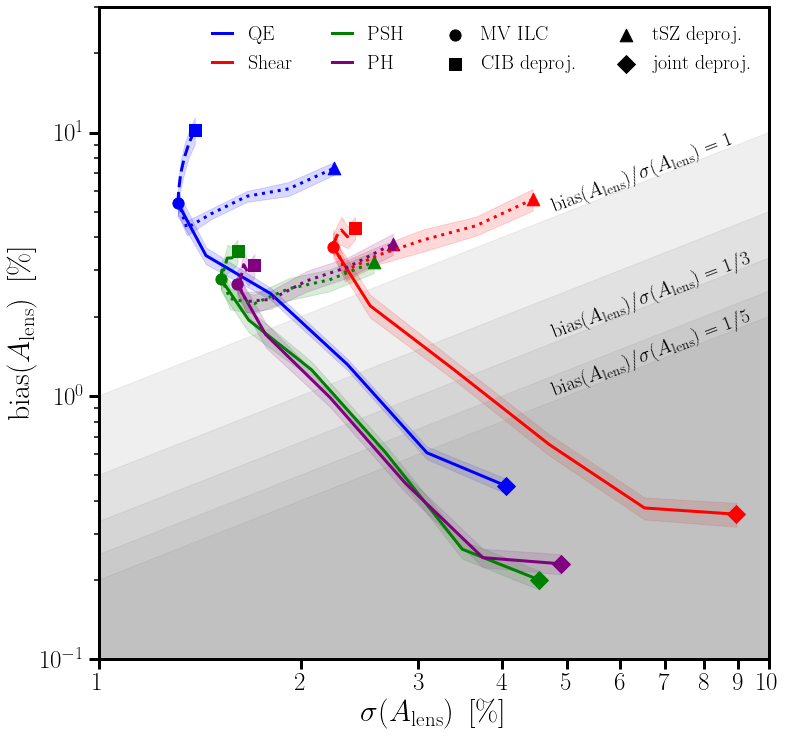

In [30]:
plt.figure(figsize=(12,12))
alpha=0.15

biases_abs = 100*np.array([mean_00,mean_02,mean_04,mean_06,mean_08,mean_10]).T
sigmas_abs = 100*np.array([std_00,std_02,std_04,std_06,std_08,std_10]).T
noises_abs = 100*np.array([noises_00,noises_02,noises_04,noises_06,noises_08,noises_10]).T

plt.plot(noises_abs[0],biases_abs[0],lw=3,c='b')
plt.plot(noises_abs[1],biases_abs[1],lw=3,c='r')
plt.plot(noises_abs[2],biases_abs[2],lw=3,c='g')
plt.plot(noises_abs[3],biases_abs[3],lw=3,c='purple')

plt.fill_between(noises_abs[0],biases_abs[0]-sigmas_abs[0],biases_abs[0]+sigmas_abs[0],color='b',alpha=alpha)
plt.fill_between(noises_abs[1],biases_abs[1]-sigmas_abs[1],biases_abs[1]+sigmas_abs[1],color='r',alpha=alpha)
plt.fill_between(noises_abs[2],biases_abs[2]-sigmas_abs[2],biases_abs[2]+sigmas_abs[2],color='g',alpha=alpha)
plt.fill_between(noises_abs[3],biases_abs[3]-sigmas_abs[3],biases_abs[3]+sigmas_abs[3],color='purple',alpha=alpha)

biases_absa = 100*np.array([mean_00a,mean_02a,mean_04a,mean_06a,mean_08a,mean_10a]).T
sigmas_absa = 100*np.array([std_00a,std_02a,std_04a,std_06a,std_08a,std_10a]).T
noises_absa = 100*np.array([noises_00a,noises_02a,noises_04a,noises_06a,noises_08a,noises_10a]).T

plt.plot(noises_absa[0],biases_absa[0],lw=3,c='b',ls='--')
plt.plot(noises_absa[1],biases_absa[1],lw=3,c='r',ls='--')
plt.plot(noises_absa[2],biases_absa[2],markersize=10,lw=3,c='g',ls='--')
plt.plot(noises_absa[3],biases_absa[3],markersize=10,lw=3,c='purple',ls='--')

plt.fill_between(noises_absa[0],biases_absa[0]-sigmas_absa[0],biases_absa[0]+sigmas_absa[0],color='b',alpha=alpha)
plt.fill_between(noises_absa[1],biases_absa[1]-sigmas_absa[1],biases_absa[1]+sigmas_absa[1],color='r',alpha=alpha)
plt.fill_between(noises_absa[2],biases_absa[2]-sigmas_absa[2],biases_absa[2]+sigmas_absa[2],color='g',alpha=alpha)
plt.fill_between(noises_absa[3],biases_absa[3]-sigmas_absa[3],biases_absa[3]+sigmas_absa[3],color='purple',alpha=alpha)

biases_absb = 100*np.array([mean_00b,mean_02b,mean_04b,mean_06b,mean_08b,mean_10b]).T
sigmas_absb = 100*np.array([std_00b,std_02b,std_04b,std_06b,std_08b,std_10b]).T
noises_absb = 100*np.array([noises_00b,noises_02b,noises_04b,noises_06b,noises_08b,noises_10b]).T

plt.plot(noises_absb[0],biases_absb[0],lw=3,c='b',ls='dotted')
plt.plot(noises_absb[1],biases_absb[1],lw=3,c='r',ls='dotted')
plt.plot(noises_absb[2],biases_absb[2],lw=3,c='g',ls='dotted')
plt.plot(noises_absb[3],biases_absb[3],lw=3,c='purple',ls='dotted')

plt.fill_between(noises_absb[0],biases_absb[0]-sigmas_absb[0],biases_absb[0]+sigmas_absb[0],color='b',alpha=alpha)
plt.fill_between(noises_absb[1],biases_absb[1]-sigmas_absb[1],biases_absb[1]+sigmas_absb[1],color='r',alpha=alpha)
plt.fill_between(noises_absb[2],biases_absb[2]-sigmas_absb[2],biases_absb[2]+sigmas_absb[2],color='g',alpha=alpha)
plt.fill_between(noises_absb[3],biases_absb[3]-sigmas_absb[3],biases_absb[3]+sigmas_absb[3],color='purple',alpha=alpha)

plt.plot([],[],c='b',lw=3,label='QE')
plt.plot([],[],c='r',lw=3,label='Shear')
plt.plot([],[],c='g',lw=3,label='PSH')
plt.plot([],[],c='purple',lw=3,label='PH')

plt.scatter([],[],color='k',s=500,marker='.',label='MV ILC')
plt.scatter([],[],color='k',s=160,marker='s',label='CIB deproj.')
plt.scatter([],[],color='k',s=160,marker='^',label='tSZ deproj.')
plt.scatter([],[],color='k',s=160,marker='D',label='joint deproj.')

domain = 100*np.linspace(1e-2,1e-1,100)
plt.fill_between(domain,domain,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/2,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/3,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/4,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/5,domain*0,color='gray',alpha=0.12)

plt.legend(frameon=False,fontsize=20,loc='upper right',ncol=4,handlelength=1)
plt.xlabel(r'$\sigma(A_\text{lens})\,\,\,[\%]$')
plt.ylabel(r'$\text{bias}(A_\text{lens})\,\,\,[\%]$')

plt.xscale('log')
plt.yscale('log')

plt.text(100*0.047,100*0.05,r'$\text{bias}(A_\text{lens})/\sigma(A_\text{lens})=1$',rotation=21,fontsize=20)
plt.text(100*0.047,100*0.05/3,r'$\text{bias}(A_\text{lens})/\sigma(A_\text{lens})=1/3$',rotation=21,fontsize=20)
plt.text(100*0.047,100*0.05/5,r'$\text{bias}(A_\text{lens})/\sigma(A_\text{lens})=1/5$',rotation=21,fontsize=20)

plt.scatter(noises_abs[0][0],biases_abs[0][0],color='b',s=500,marker='.')
plt.scatter(noises_abs[1][0],biases_abs[1][0],color='r',s=500,marker='.')
plt.scatter(noises_abs[2][0],biases_abs[2][0],color='g',s=500,marker='.')
plt.scatter(noises_abs[3][0],biases_abs[3][0],color='purple',s=500,marker='.')

plt.scatter(noises_abs[0][-1],biases_abs[0][-1],color='b',s=160,marker='D')
plt.scatter(noises_abs[1][-1],biases_abs[1][-1],color='r',s=160,marker='D')
plt.scatter(noises_abs[2][-1],biases_abs[2][-1],color='g',s=160,marker='D')
plt.scatter(noises_abs[3][-1],biases_abs[3][-1],color='purple',s=160,marker='D')

plt.scatter(noises_absa[0][-1],biases_absa[0][-1],color='b',s=160,marker='s')
plt.scatter(noises_absa[1][-1],biases_absa[1][-1],color='r',s=160,marker='s')
plt.scatter(noises_absa[2][-1],biases_absa[2][-1],color='g',s=160,marker='s')
plt.scatter(noises_absa[3][-1],biases_absa[3][-1],color='purple',s=160,marker='s')

plt.scatter(noises_absb[0][-1],biases_absb[0][-1],color='b',s=160,marker='^')
plt.scatter(noises_absb[1][-1],biases_absb[1][-1],color='r',s=160,marker='^')
plt.scatter(noises_absb[2][-1],biases_absb[2][-1],color='g',s=160,marker='^')
plt.scatter(noises_absb[3][-1],biases_absb[3][-1],color='purple',s=160,marker='^')

plt.xticks([1,2,3,4,5,6,7,8,9,10],labels=[1,2,3,4,5,6,7,8,9,10])

plt.xlim(100*0.01,100*0.1)
#plt.xlim(6e-3,5e-2)
plt.ylim(100*1e-3,100*0.3)
plt.savefig('figures/auto_bias_vs_noise_'+str(int(lMax))+'_abs.pdf',bbox_inches='tight')

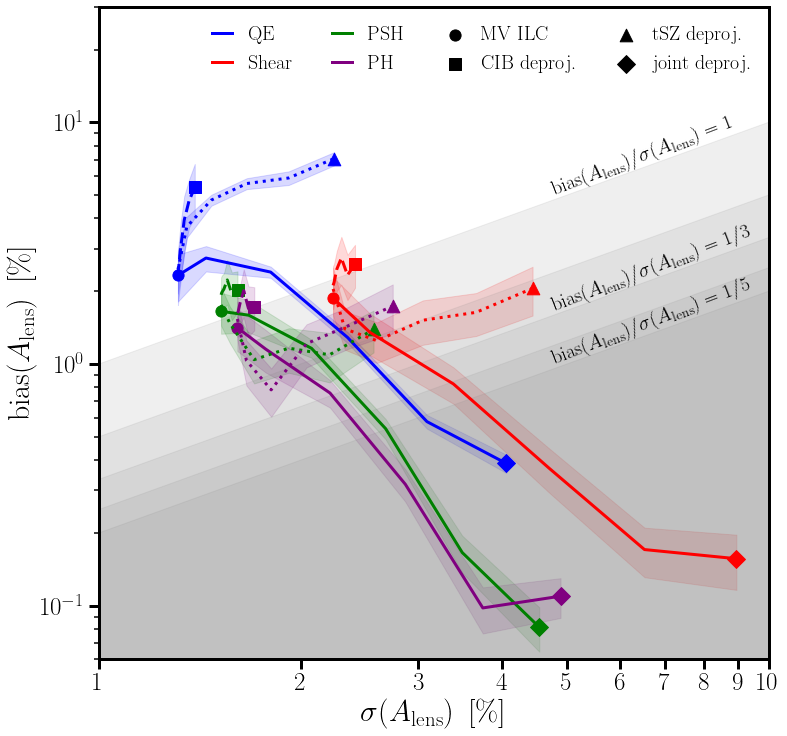

In [31]:
plt.figure(figsize=(12,12))
alpha=0.15

biases_abs = 100*np.array([mean2_00,mean2_02,mean2_04,mean2_06,mean2_08,mean2_10]).T
sigmas_abs = 100*np.array([std2_00,std2_02,std2_04,std2_06,std2_08,std2_10]).T
noises_abs = 100*np.array([noises_00,noises_02,noises_04,noises_06,noises_08,noises_10]).T

plt.plot(noises_abs[0],biases_abs[0],lw=3,c='b')
plt.plot(noises_abs[1],biases_abs[1],lw=3,c='r')
plt.plot(noises_abs[2],biases_abs[2],lw=3,c='g')
plt.plot(noises_abs[3],biases_abs[3],lw=3,c='purple')

plt.fill_between(noises_abs[0],biases_abs[0]-sigmas_abs[0],biases_abs[0]+sigmas_abs[0],color='b',alpha=alpha)
plt.fill_between(noises_abs[1],biases_abs[1]-sigmas_abs[1],biases_abs[1]+sigmas_abs[1],color='r',alpha=alpha)
plt.fill_between(noises_abs[2],biases_abs[2]-sigmas_abs[2],biases_abs[2]+sigmas_abs[2],color='g',alpha=alpha)
plt.fill_between(noises_abs[3],biases_abs[3]-sigmas_abs[3],biases_abs[3]+sigmas_abs[3],color='purple',alpha=alpha)

biases_absa = 100*np.array([mean2_00a,mean2_02a,mean2_04a,mean2_06a,mean2_08a,mean2_10a]).T
sigmas_absa = 100*np.array([std2_00a,std2_02a,std2_04a,std2_06a,std2_08a,std2_10a]).T
noises_absa = 100*np.array([noises_00a,noises_02a,noises_04a,noises_06a,noises_08a,noises_10a]).T

plt.plot(noises_absa[0],biases_absa[0],lw=3,c='b',ls='--')
plt.plot(noises_absa[1],biases_absa[1],lw=3,c='r',ls='--')
plt.plot(noises_absa[2],biases_absa[2],markersize=10,lw=3,c='g',ls='--')
plt.plot(noises_absa[3],biases_absa[3],markersize=10,lw=3,c='purple',ls='--')

plt.fill_between(noises_absa[0],biases_absa[0]-sigmas_absa[0],biases_absa[0]+sigmas_absa[0],color='b',alpha=alpha)
plt.fill_between(noises_absa[1],biases_absa[1]-sigmas_absa[1],biases_absa[1]+sigmas_absa[1],color='r',alpha=alpha)
plt.fill_between(noises_absa[2],biases_absa[2]-sigmas_absa[2],biases_absa[2]+sigmas_absa[2],color='g',alpha=alpha)
plt.fill_between(noises_absa[3],biases_absa[3]-sigmas_absa[3],biases_absa[3]+sigmas_absa[3],color='purple',alpha=alpha)

biases_absb = 100*np.array([mean2_00b,mean2_02b,mean2_04b,mean2_06b,mean2_08b,mean2_10b]).T
sigmas_absb = 100*np.array([std2_00b,std2_02b,std2_04b,std2_06b,std2_08b,std2_10b]).T
noises_absb = 100*np.array([noises_00b,noises_02b,noises_04b,noises_06b,noises_08b,noises_10b]).T

plt.plot(noises_absb[0],biases_absb[0],lw=3,c='b',ls='dotted')
plt.plot(noises_absb[1],biases_absb[1],lw=3,c='r',ls='dotted')
plt.plot(noises_absb[2],biases_absb[2],lw=3,c='g',ls='dotted')
plt.plot(noises_absb[3],biases_absb[3],lw=3,c='purple',ls='dotted')

plt.fill_between(noises_absb[0],biases_absb[0]-sigmas_absb[0],biases_absb[0]+sigmas_absb[0],color='b',alpha=alpha)
plt.fill_between(noises_absb[1],biases_absb[1]-sigmas_absb[1],biases_absb[1]+sigmas_absb[1],color='r',alpha=alpha)
plt.fill_between(noises_absb[2],biases_absb[2]-sigmas_absb[2],biases_absb[2]+sigmas_absb[2],color='g',alpha=alpha)
plt.fill_between(noises_absb[3],biases_absb[3]-sigmas_absb[3],biases_absb[3]+sigmas_absb[3],color='purple',alpha=alpha)

plt.plot([],[],c='b',lw=3,label='QE')
plt.plot([],[],c='r',lw=3,label='Shear')
plt.plot([],[],c='g',lw=3,label='PSH')
plt.plot([],[],c='purple',lw=3,label='PH')

plt.scatter([],[],color='k',s=500,marker='.',label='MV ILC')
plt.scatter([],[],color='k',s=160,marker='s',label='CIB deproj.')
plt.scatter([],[],color='k',s=160,marker='^',label='tSZ deproj.')
plt.scatter([],[],color='k',s=160,marker='D',label='joint deproj.')

domain = 100*np.linspace(1e-2,1e-1,100)
plt.fill_between(domain,domain,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/2,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/3,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/4,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/5,domain*0,color='gray',alpha=0.12)

plt.legend(frameon=False,fontsize=20,loc='upper right',ncol=4,handlelength=1)
plt.xlabel(r'$\sigma(A_\text{lens})\,\,\,[\%]$')
plt.ylabel(r'$\text{bias}(A_\text{lens})\,\,\,[\%]$')

plt.xscale('log')
plt.yscale('log')

plt.text(100*0.047,100*0.05,r'$\text{bias}(A_\text{lens})/\sigma(A_\text{lens})=1$',rotation=21,fontsize=20)
plt.text(100*0.047,100*0.05/3,r'$\text{bias}(A_\text{lens})/\sigma(A_\text{lens})=1/3$',rotation=21,fontsize=20)
plt.text(100*0.047,100*0.05/5,r'$\text{bias}(A_\text{lens})/\sigma(A_\text{lens})=1/5$',rotation=21,fontsize=20)

plt.scatter(noises_abs[0][0],biases_abs[0][0],color='b',s=500,marker='.')
plt.scatter(noises_abs[1][0],biases_abs[1][0],color='r',s=500,marker='.')
plt.scatter(noises_abs[2][0],biases_abs[2][0],color='g',s=500,marker='.')
plt.scatter(noises_abs[3][0],biases_abs[3][0],color='purple',s=500,marker='.')

plt.scatter(noises_abs[0][-1],biases_abs[0][-1],color='b',s=160,marker='D')
plt.scatter(noises_abs[1][-1],biases_abs[1][-1],color='r',s=160,marker='D')
plt.scatter(noises_abs[2][-1],biases_abs[2][-1],color='g',s=160,marker='D')
plt.scatter(noises_abs[3][-1],biases_abs[3][-1],color='purple',s=160,marker='D')

plt.scatter(noises_absa[0][-1],biases_absa[0][-1],color='b',s=160,marker='s')
plt.scatter(noises_absa[1][-1],biases_absa[1][-1],color='r',s=160,marker='s')
plt.scatter(noises_absa[2][-1],biases_absa[2][-1],color='g',s=160,marker='s')
plt.scatter(noises_absa[3][-1],biases_absa[3][-1],color='purple',s=160,marker='s')

plt.scatter(noises_absb[0][-1],biases_absb[0][-1],color='b',s=160,marker='^')
plt.scatter(noises_absb[1][-1],biases_absb[1][-1],color='r',s=160,marker='^')
plt.scatter(noises_absb[2][-1],biases_absb[2][-1],color='g',s=160,marker='^')
plt.scatter(noises_absb[3][-1],biases_absb[3][-1],color='purple',s=160,marker='^')

plt.xticks([1,2,3,4,5,6,7,8,9,10],labels=[1,2,3,4,5,6,7,8,9,10])

plt.xlim(100*0.01,100*0.1)
#plt.xlim(6e-3,5e-2)
plt.ylim(100*6e-4,100*0.3)
plt.savefig('figures/auto_bias_vs_noise_'+str(int(lMax))+'_true.pdf',bbox_inches='tight')

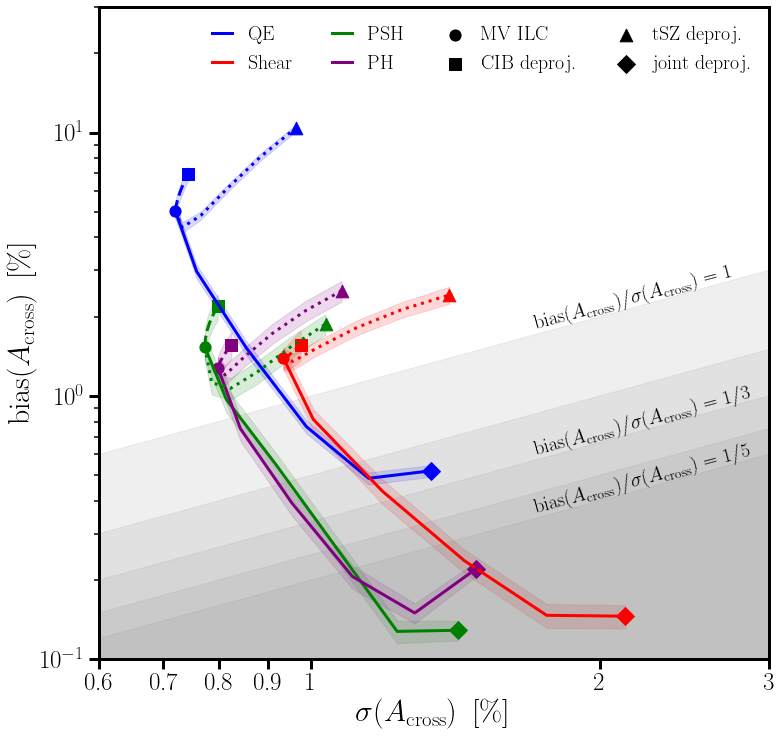

In [43]:
plt.figure(figsize=(12,12))
alpha=0.15

biases_abs = 100*np.array([meanx_00,meanx_02,meanx_04,meanx_06,meanx_08,meanx_10]).T
sigmas_abs = 100*np.array([stdx_00,stdx_02,stdx_04,stdx_06,stdx_08,stdx_10]).T
noises_abs = 100*np.array([noisesx_00,noisesx_02,noisesx_04,noisesx_06,noisesx_08,noisesx_10]).T

plt.plot(noises_abs[0],biases_abs[0],lw=3,c='b')
plt.plot(noises_abs[1],biases_abs[1],lw=3,c='r')
plt.plot(noises_abs[2],biases_abs[2],lw=3,c='g')
plt.plot(noises_abs[3],biases_abs[3],lw=3,c='purple')

plt.fill_between(noises_abs[0],biases_abs[0]-sigmas_abs[0],biases_abs[0]+sigmas_abs[0],color='b',alpha=alpha)
plt.fill_between(noises_abs[1],biases_abs[1]-sigmas_abs[1],biases_abs[1]+sigmas_abs[1],color='r',alpha=alpha)
plt.fill_between(noises_abs[2],biases_abs[2]-sigmas_abs[2],biases_abs[2]+sigmas_abs[2],color='g',alpha=alpha)
plt.fill_between(noises_abs[3],biases_abs[3]-sigmas_abs[3],biases_abs[3]+sigmas_abs[3],color='purple',alpha=alpha)

biases_absa = 100*np.array([meanx_00a,meanx_02a,meanx_04a,meanx_06a,meanx_08a,meanx_10a]).T
sigmas_absa = 100*np.array([stdx_00a,stdx_02a,stdx_04a,stdx_06a,stdx_08a,stdx_10a]).T
noises_absa = 100*np.array([noisesx_00a,noisesx_02a,noisesx_04a,noisesx_06a,noisesx_08a,noisesx_10a]).T

plt.plot(noises_absa[0],biases_absa[0],lw=3,c='b',ls='--')
plt.plot(noises_absa[1],biases_absa[1],lw=3,c='r',ls='--')
plt.plot(noises_absa[2],biases_absa[2],markersize=10,lw=3,c='g',ls='--')
plt.plot(noises_absa[3],biases_absa[3],markersize=10,lw=3,c='purple',ls='--')

plt.fill_between(noises_absa[0],biases_absa[0]-sigmas_absa[0],biases_absa[0]+sigmas_absa[0],color='b',alpha=alpha)
plt.fill_between(noises_absa[1],biases_absa[1]-sigmas_absa[1],biases_absa[1]+sigmas_absa[1],color='r',alpha=alpha)
plt.fill_between(noises_absa[2],biases_absa[2]-sigmas_absa[2],biases_absa[2]+sigmas_absa[2],color='g',alpha=alpha)
plt.fill_between(noises_absa[3],biases_absa[3]-sigmas_absa[3],biases_absa[3]+sigmas_absa[3],color='purple',alpha=alpha)

biases_absb = 100*np.array([meanx_00b,meanx_02b,meanx_04b,meanx_06b,meanx_08b,meanx_10b]).T
sigmas_absb = 100*np.array([stdx_00b,stdx_02b,stdx_04b,stdx_06b,stdx_08b,stdx_10b]).T
noises_absb = 100*np.array([noisesx_00b,noisesx_02b,noisesx_04b,noisesx_06b,noisesx_08b,noisesx_10b]).T

plt.plot(noises_absb[0],biases_absb[0],lw=3,c='b',ls='dotted')
plt.plot(noises_absb[1],biases_absb[1],lw=3,c='r',ls='dotted')
plt.plot(noises_absb[2],biases_absb[2],lw=3,c='g',ls='dotted')
plt.plot(noises_absb[3],biases_absb[3],lw=3,c='purple',ls='dotted')

plt.fill_between(noises_absb[0],biases_absb[0]-sigmas_absb[0],biases_absb[0]+sigmas_absb[0],color='b',alpha=alpha)
plt.fill_between(noises_absb[1],biases_absb[1]-sigmas_absb[1],biases_absb[1]+sigmas_absb[1],color='r',alpha=alpha)
plt.fill_between(noises_absb[2],biases_absb[2]-sigmas_absb[2],biases_absb[2]+sigmas_absb[2],color='g',alpha=alpha)
plt.fill_between(noises_absb[3],biases_absb[3]-sigmas_absb[3],biases_absb[3]+sigmas_absb[3],color='purple',alpha=alpha)

plt.plot([],[],c='b',lw=3,label='QE')
plt.plot([],[],c='r',lw=3,label='Shear')
plt.plot([],[],c='g',lw=3,label='PSH')
plt.plot([],[],c='purple',lw=3,label='PH')

plt.scatter([],[],color='k',s=500,marker='.',label='MV ILC')
plt.scatter([],[],color='k',s=160,marker='s',label='CIB deproj.')
plt.scatter([],[],color='k',s=160,marker='^',label='tSZ deproj.')
plt.scatter([],[],color='k',s=160,marker='D',label='joint deproj.')

domain = 100*np.linspace(1e-3,1e-1,100)
plt.fill_between(domain,domain,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/2,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/3,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/4,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/5,domain*0,color='gray',alpha=0.12)

plt.legend(frameon=False,fontsize=20,loc='upper right',ncol=4,handlelength=1)
plt.xlabel(r'$\sigma(A_\text{cross})\,\,\,[\%]$')
plt.ylabel(r'$\text{bias}(A_\text{cross})\,\,\,[\%]$')

plt.xscale('log')
plt.yscale('log')

plt.text(100*0.017,100*0.018,r'$\text{bias}(A_\text{cross})/\sigma(A_\text{cross})=1$',rotation=15,fontsize=20)
plt.text(100*0.017,100*0.018/3,r'$\text{bias}(A_\text{cross})/\sigma(A_\text{cross})=1/3$',rotation=15,fontsize=20)
plt.text(100*0.017,100*0.018/5,r'$\text{bias}(A_\text{cross})/\sigma(A_\text{cross})=1/5$',rotation=15,fontsize=20)

plt.scatter(noises_abs[0][0],biases_abs[0][0],color='b',s=500,marker='.')
plt.scatter(noises_abs[1][0],biases_abs[1][0],color='r',s=500,marker='.')
plt.scatter(noises_abs[2][0],biases_abs[2][0],color='g',s=500,marker='.')
plt.scatter(noises_abs[3][0],biases_abs[3][0],color='purple',s=500,marker='.')

plt.scatter(noises_abs[0][-1],biases_abs[0][-1],color='b',s=160,marker='D')
plt.scatter(noises_abs[1][-1],biases_abs[1][-1],color='r',s=160,marker='D')
plt.scatter(noises_abs[2][-1],biases_abs[2][-1],color='g',s=160,marker='D')
plt.scatter(noises_abs[3][-1],biases_abs[3][-1],color='purple',s=160,marker='D')

plt.scatter(noises_absa[0][-1],biases_absa[0][-1],color='b',s=160,marker='s')
plt.scatter(noises_absa[1][-1],biases_absa[1][-1],color='r',s=160,marker='s')
plt.scatter(noises_absa[2][-1],biases_absa[2][-1],color='g',s=160,marker='s')
plt.scatter(noises_absa[3][-1],biases_absa[3][-1],color='purple',s=160,marker='s')

plt.scatter(noises_absb[0][-1],biases_absb[0][-1],color='b',s=160,marker='^')
plt.scatter(noises_absb[1][-1],biases_absb[1][-1],color='r',s=160,marker='^')
plt.scatter(noises_absb[2][-1],biases_absb[2][-1],color='g',s=160,marker='^')
plt.scatter(noises_absb[3][-1],biases_absb[3][-1],color='purple',s=160,marker='^')

plt.xticks([0.6,0.7,0.8,0.9,1,2,3],labels=[0.6,0.7,0.8,0.9,1,2,3])

plt.xlim(0.6,3)
#plt.xlim(6e-3,5e-2)
plt.ylim(100*1e-3,100*0.3)
plt.savefig('figures/cross_bias_vs_noise_'+str(int(lMax))+'_abs.pdf',bbox_inches='tight')

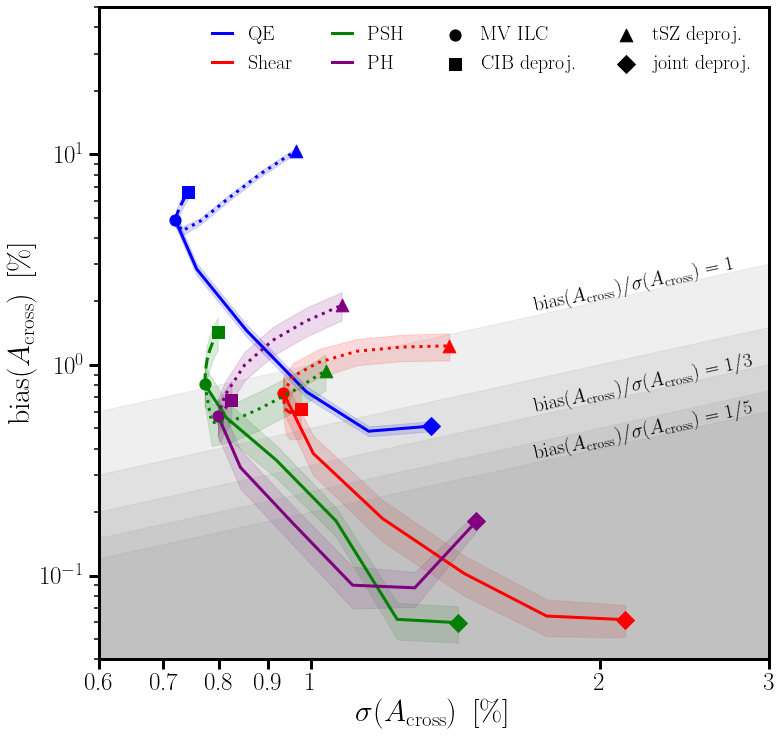

In [40]:
plt.figure(figsize=(12,12))
alpha=0.15

biases_abs = 100*np.array([mean2x_00,mean2x_02,mean2x_04,mean2x_06,mean2x_08,mean2x_10]).T
sigmas_abs = 100*np.array([std2x_00,std2x_02,std2x_04,std2x_06,std2x_08,std2x_10]).T
noises_abs = 100*np.array([noisesx_00,noisesx_02,noisesx_04,noisesx_06,noisesx_08,noisesx_10]).T

plt.plot(noises_abs[0],biases_abs[0],lw=3,c='b')
plt.plot(noises_abs[1],biases_abs[1],lw=3,c='r')
plt.plot(noises_abs[2],biases_abs[2],lw=3,c='g')
plt.plot(noises_abs[3],biases_abs[3],lw=3,c='purple')

plt.fill_between(noises_abs[0],biases_abs[0]-sigmas_abs[0],biases_abs[0]+sigmas_abs[0],color='b',alpha=alpha)
plt.fill_between(noises_abs[1],biases_abs[1]-sigmas_abs[1],biases_abs[1]+sigmas_abs[1],color='r',alpha=alpha)
plt.fill_between(noises_abs[2],biases_abs[2]-sigmas_abs[2],biases_abs[2]+sigmas_abs[2],color='g',alpha=alpha)
plt.fill_between(noises_abs[3],biases_abs[3]-sigmas_abs[3],biases_abs[3]+sigmas_abs[3],color='purple',alpha=alpha)

biases_absa = 100*np.array([mean2x_00a,mean2x_02a,mean2x_04a,mean2x_06a,mean2x_08a,mean2x_10a]).T
sigmas_absa = 100*np.array([std2x_00a,std2x_02a,std2x_04a,std2x_06a,std2x_08a,std2x_10a]).T
noises_absa = 100*np.array([noisesx_00a,noisesx_02a,noisesx_04a,noisesx_06a,noisesx_08a,noisesx_10a]).T

plt.plot(noises_absa[0],biases_absa[0],lw=3,c='b',ls='--')
plt.plot(noises_absa[1],biases_absa[1],lw=3,c='r',ls='--')
plt.plot(noises_absa[2],biases_absa[2],markersize=10,lw=3,c='g',ls='--')
plt.plot(noises_absa[3],biases_absa[3],markersize=10,lw=3,c='purple',ls='--')

plt.fill_between(noises_absa[0],biases_absa[0]-sigmas_absa[0],biases_absa[0]+sigmas_absa[0],color='b',alpha=alpha)
plt.fill_between(noises_absa[1],biases_absa[1]-sigmas_absa[1],biases_absa[1]+sigmas_absa[1],color='r',alpha=alpha)
plt.fill_between(noises_absa[2],biases_absa[2]-sigmas_absa[2],biases_absa[2]+sigmas_absa[2],color='g',alpha=alpha)
plt.fill_between(noises_absa[3],biases_absa[3]-sigmas_absa[3],biases_absa[3]+sigmas_absa[3],color='purple',alpha=alpha)

biases_absb = 100*np.array([mean2x_00b,mean2x_02b,mean2x_04b,mean2x_06b,mean2x_08b,mean2x_10b]).T
sigmas_absb = 100*np.array([std2x_00b,std2x_02b,std2x_04b,std2x_06b,std2x_08b,std2x_10b]).T
noises_absb = 100*np.array([noisesx_00b,noisesx_02b,noisesx_04b,noisesx_06b,noisesx_08b,noisesx_10b]).T

plt.plot(noises_absb[0],biases_absb[0],lw=3,c='b',ls='dotted')
plt.plot(noises_absb[1],biases_absb[1],lw=3,c='r',ls='dotted')
plt.plot(noises_absb[2],biases_absb[2],lw=3,c='g',ls='dotted')
plt.plot(noises_absb[3],biases_absb[3],lw=3,c='purple',ls='dotted')

plt.fill_between(noises_absb[0],biases_absb[0]-sigmas_absb[0],biases_absb[0]+sigmas_absb[0],color='b',alpha=alpha)
plt.fill_between(noises_absb[1],biases_absb[1]-sigmas_absb[1],biases_absb[1]+sigmas_absb[1],color='r',alpha=alpha)
plt.fill_between(noises_absb[2],biases_absb[2]-sigmas_absb[2],biases_absb[2]+sigmas_absb[2],color='g',alpha=alpha)
plt.fill_between(noises_absb[3],biases_absb[3]-sigmas_absb[3],biases_absb[3]+sigmas_absb[3],color='purple',alpha=alpha)

plt.plot([],[],c='b',lw=3,label='QE')
plt.plot([],[],c='r',lw=3,label='Shear')
plt.plot([],[],c='g',lw=3,label='PSH')
plt.plot([],[],c='purple',lw=3,label='PH')

plt.scatter([],[],color='k',s=500,marker='.',label='MV ILC')
plt.scatter([],[],color='k',s=160,marker='s',label='CIB deproj.')
plt.scatter([],[],color='k',s=160,marker='^',label='tSZ deproj.')
plt.scatter([],[],color='k',s=160,marker='D',label='joint deproj.')

domain = 100*np.linspace(1e-3,1e-1,100)
plt.fill_between(domain,domain,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/2,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/3,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/4,domain*0,color='gray',alpha=0.12)
plt.fill_between(domain,domain/5,domain*0,color='gray',alpha=0.12)

plt.legend(frameon=False,fontsize=20,loc='upper right',ncol=4,handlelength=1)
plt.xlabel(r'$\sigma(A_\text{cross})\,\,\,[\%]$')
plt.ylabel(r'$\text{bias}(A_\text{cross})\,\,\,[\%]$')

plt.xscale('log')
plt.yscale('log')

plt.text(100*0.017,100*0.018,r'$\text{bias}(A_\text{cross})/\sigma(A_\text{cross})=1$',rotation=12,fontsize=20)
plt.text(100*0.017,100*0.018/3,r'$\text{bias}(A_\text{cross})/\sigma(A_\text{cross})=1/3$',rotation=12,fontsize=20)
plt.text(100*0.017,100*0.018/5,r'$\text{bias}(A_\text{cross})/\sigma(A_\text{cross})=1/5$',rotation=12,fontsize=20)

plt.scatter(noises_abs[0][0],biases_abs[0][0],color='b',s=500,marker='.')
plt.scatter(noises_abs[1][0],biases_abs[1][0],color='r',s=500,marker='.')
plt.scatter(noises_abs[2][0],biases_abs[2][0],color='g',s=500,marker='.')
plt.scatter(noises_abs[3][0],biases_abs[3][0],color='purple',s=500,marker='.')

plt.scatter(noises_abs[0][-1],biases_abs[0][-1],color='b',s=160,marker='D')
plt.scatter(noises_abs[1][-1],biases_abs[1][-1],color='r',s=160,marker='D')
plt.scatter(noises_abs[2][-1],biases_abs[2][-1],color='g',s=160,marker='D')
plt.scatter(noises_abs[3][-1],biases_abs[3][-1],color='purple',s=160,marker='D')

plt.scatter(noises_absa[0][-1],biases_absa[0][-1],color='b',s=160,marker='s')
plt.scatter(noises_absa[1][-1],biases_absa[1][-1],color='r',s=160,marker='s')
plt.scatter(noises_absa[2][-1],biases_absa[2][-1],color='g',s=160,marker='s')
plt.scatter(noises_absa[3][-1],biases_absa[3][-1],color='purple',s=160,marker='s')

plt.scatter(noises_absb[0][-1],biases_absb[0][-1],color='b',s=160,marker='^')
plt.scatter(noises_absb[1][-1],biases_absb[1][-1],color='r',s=160,marker='^')
plt.scatter(noises_absb[2][-1],biases_absb[2][-1],color='g',s=160,marker='^')
plt.scatter(noises_absb[3][-1],biases_absb[3][-1],color='purple',s=160,marker='^')

plt.xticks([0.6,0.7,0.8,0.9,1,2,3],labels=[0.6,0.7,0.8,0.9,1,2,3])

plt.xlim(0.6,3)
#plt.xlim(6e-3,5e-2)
plt.ylim(100*4e-4,100*0.5)
plt.savefig('figures/cross_bias_vs_noise_'+str(int(lMax))+'_true.pdf',bbox_inches='tight')

In [38]:
biases_abs = 100*np.array([mean_00,mean_02,mean_04,mean_06,mean_08,mean_10]).T
sigmas_abs = 100*np.array([std_00,std_02,std_04,std_06,std_08,std_10]).T
noises_abs = 100*np.array([noises_00,noises_02,noises_04,noises_06,noises_08,noises_10]).T

biases_absa = 100*np.array([mean_00a,mean_02a,mean_04a,mean_06a,mean_08a,mean_10a]).T
sigmas_absa = 100*np.array([std_00a,std_02a,std_04a,std_06a,std_08a,std_10a]).T
noises_absa = 100*np.array([noises_00a,noises_02a,noises_04a,noises_06a,noises_08a,noises_10a]).T

biases_absb = 100*np.array([mean_00b,mean_02b,mean_04b,mean_06b,mean_08b,mean_10b]).T
sigmas_absb = 100*np.array([std_00b,std_02b,std_04b,std_06b,std_08b,std_10b]).T
noises_absb = 100*np.array([noises_00b,noises_02b,noises_04b,noises_06b,noises_08b,noises_10b]).T

data = np.array([biases_abs,sigmas_abs,noises_abs,biases_absa,sigmas_absa,noises_absa,biases_absb,sigmas_absb,noises_absb]).flatten()
np.savetxt('output/summary_'+str(int(lMax))+'_abs_auto.txt',data)

##############################################################################################

biases_abs = 100*np.array([mean2_00,mean2_02,mean2_04,mean2_06,mean2_08,mean2_10]).T
sigmas_abs = 100*np.array([std2_00,std2_02,std2_04,std2_06,std2_08,std2_10]).T
noises_abs = 100*np.array([noises_00,noises_02,noises_04,noises_06,noises_08,noises_10]).T

biases_absa = 100*np.array([mean2_00a,mean2_02a,mean2_04a,mean2_06a,mean2_08a,mean2_10a]).T
sigmas_absa = 100*np.array([std2_00a,std2_02a,std2_04a,std2_06a,std2_08a,std2_10a]).T
noises_absa = 100*np.array([noises_00a,noises_02a,noises_04a,noises_06a,noises_08a,noises_10a]).T

biases_absb = 100*np.array([mean2_00b,mean2_02b,mean2_04b,mean2_06b,mean2_08b,mean2_10b]).T
sigmas_absb = 100*np.array([std2_00b,std2_02b,std2_04b,std2_06b,std2_08b,std2_10b]).T
noises_absb = 100*np.array([noises_00b,noises_02b,noises_04b,noises_06b,noises_08b,noises_10b]).T

data = np.array([biases_abs,sigmas_abs,noises_abs,biases_absa,sigmas_absa,noises_absa,biases_absb,sigmas_absb,noises_absb]).flatten()
np.savetxt('output/summary_'+str(int(lMax))+'_true_auto.txt',data)

##############################################################################################

biases_abs = 100*np.array([meanx_00,meanx_02,meanx_04,meanx_06,meanx_08,meanx_10]).T
sigmas_abs = 100*np.array([stdx_00,stdx_02,stdx_04,stdx_06,stdx_08,stdx_10]).T
noises_abs = 100*np.array([noisesx_00,noisesx_02,noisesx_04,noisesx_06,noisesx_08,noisesx_10]).T

biases_absa = 100*np.array([meanx_00a,meanx_02a,meanx_04a,meanx_06a,meanx_08a,meanx_10a]).T
sigmas_absa = 100*np.array([stdx_00a,stdx_02a,stdx_04a,stdx_06a,stdx_08a,stdx_10a]).T
noises_absa = 100*np.array([noisesx_00a,noisesx_02a,noisesx_04a,noisesx_06a,noisesx_08a,noisesx_10a]).T

biases_absb = 100*np.array([meanx_00b,meanx_02b,meanx_04b,meanx_06b,meanx_08b,meanx_10b]).T
sigmas_absb = 100*np.array([stdx_00b,stdx_02b,stdx_04b,stdx_06b,stdx_08b,stdx_10b]).T
noises_absb = 100*np.array([noisesx_00b,noisesx_02b,noisesx_04b,noisesx_06b,noisesx_08b,noisesx_10b]).T

data = np.array([biases_abs,sigmas_abs,noises_abs,biases_absa,sigmas_absa,noises_absa,biases_absb,sigmas_absb,noises_absb]).flatten()
np.savetxt('output/summary_'+str(int(lMax))+'_abs_cross.txt',data)

##############################################################################################

biases_abs = 100*np.array([mean2x_00,mean2x_02,mean2x_04,mean2x_06,mean2x_08,mean2x_10]).T
sigmas_abs = 100*np.array([std2x_00,std2x_02,std2x_04,std2x_06,std2x_08,std2x_10]).T
noises_abs = 100*np.array([noisesx_00,noisesx_02,noisesx_04,noisesx_06,noisesx_08,noisesx_10]).T

biases_absa = 100*np.array([mean2x_00a,mean2x_02a,mean2x_04a,mean2x_06a,mean2x_08a,mean2x_10a]).T
sigmas_absa = 100*np.array([std2x_00a,std2x_02a,std2x_04a,std2x_06a,std2x_08a,std2x_10a]).T
noises_absa = 100*np.array([noisesx_00a,noisesx_02a,noisesx_04a,noisesx_06a,noisesx_08a,noisesx_10a]).T

biases_absb = 100*np.array([mean2x_00b,mean2x_02b,mean2x_04b,mean2x_06b,mean2x_08b,mean2x_10b]).T
sigmas_absb = 100*np.array([std2x_00b,std2x_02b,std2x_04b,std2x_06b,std2x_08b,std2x_10b]).T
noises_absb = 100*np.array([noisesx_00b,noisesx_02b,noisesx_04b,noisesx_06b,noisesx_08b,noisesx_10b]).T

data = np.array([biases_abs,sigmas_abs,noises_abs,biases_absa,sigmas_absa,noises_absa,biases_absb,sigmas_absb,noises_absb]).flatten()
np.savetxt('output/summary_'+str(int(lMax))+'_true_cross.txt',data)